# Lab Assignment Two: Exploring Image Data 

## CS 7324 Fall 2023
## Catherine Magee, Morgan Mote, Luv Patel

### -------------------------------------------------------------------------------------------------------

## Buisness Understanding 

[2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data

# Data Preparation


## Loading the Dataset: Optical Recognition of Handwritten Digits

In [13]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Set the parent folder path containing subfolders for each shape's dataset
folder_path = 'C:\\Users\\Lucifer\\Desktop\\ML_project\\Lab2\\CS7324fall23\\lab2\\Image_dataset\\seg_train\\seg_train'

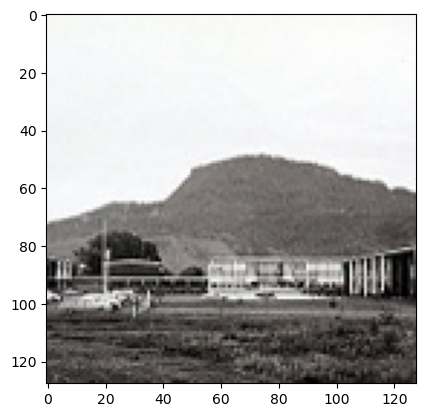

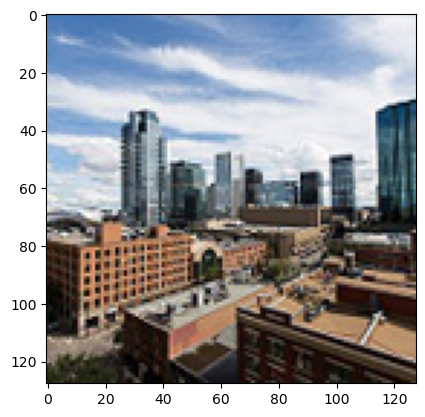

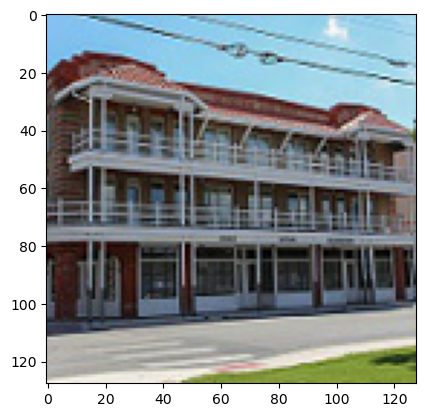

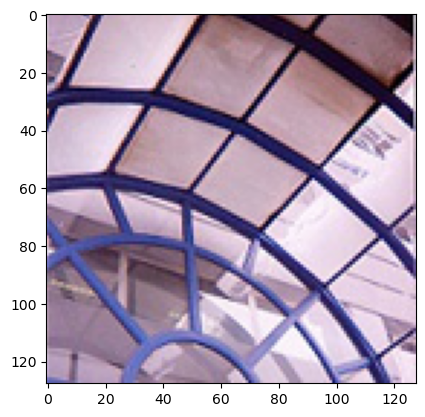

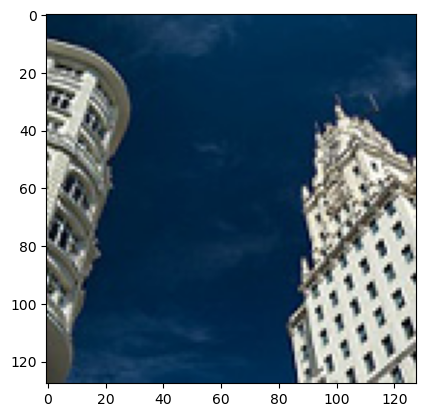

In [18]:
def load_images_from_folder(base_folder, target_size=(128, 128), color_mode="RGB", max_samples_per_category=None):
    images = []
    categories = os.listdir(base_folder)
    
    for category in categories:
        category_path = os.path.join(base_folder, category)
        
        # Ensure that it's indeed a folder
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path)[:max_samples_per_category]:
                img_path = os.path.join(category_path, filename)
                
                # Check if it's an actual file
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                    
                    # Resize and convert color
                    img = img.resize(target_size).convert(color_mode)
                    img_array = np.asarray(img)
                    images.append(img_array)
                    
    return np.array(images)

# Load images
images_array = load_images_from_folder(folder_path, max_samples_per_category=100)

# Linearize and visualize as before
linearized_images = images_array.reshape(images_array.shape[0], -1)

# Visualize several images (let's say 5)
def visualize_images(images, n=5):
    for i in range(min(n, len(images))):
        plt.imshow(images[i])
        plt.show()

visualize_images(images_array)

### Linear Dimensionality Reduction (using PCA)

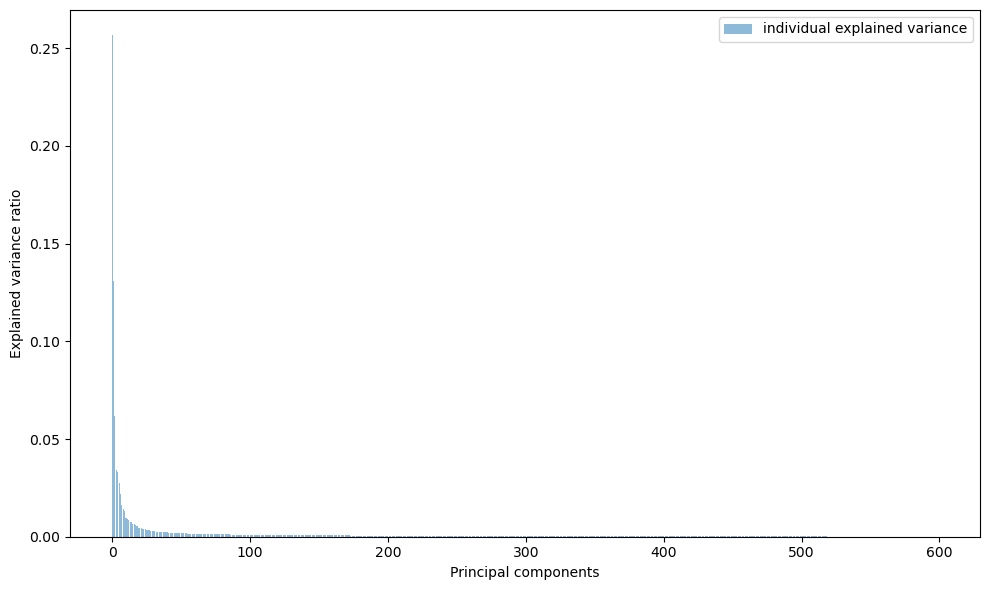

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the linearized images
pca = PCA()
pca_result = pca.fit_transform(linearized_images)

# Visualize the explained variance ratio of the components
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Linear Dimensionality Reduction (using randomized PCA)

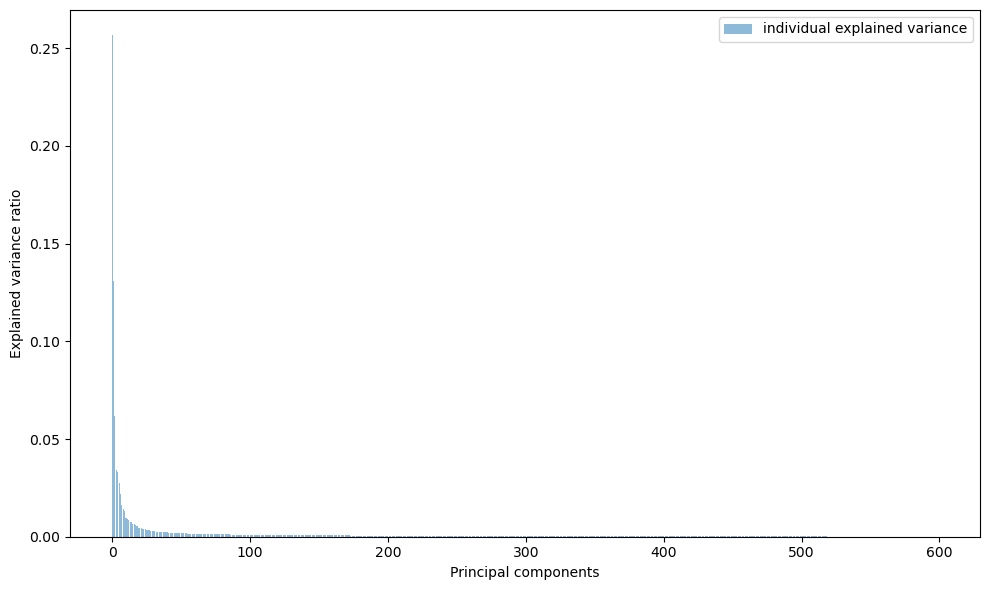

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform Randomized PCA on the linearized images
randomized_pca = PCA(svd_solver='randomized')
randomized_pca_result = randomized_pca.fit_transform(linearized_images)

# Visualize the explained variance ratio of the components
explained_variance = randomized_pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Comparing the representation using PCA and Randomized PCA.

The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

In [21]:
from sklearn.metrics import mean_squared_error

# 1. Determine Number of Components for 95% Explained Variance

def components_for_variance(explained_variance, threshold=0.95):
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold) + 1

components_pca = components_for_variance(pca.explained_variance_ratio_)
components_randomized_pca = components_for_variance(randomized_pca.explained_variance_ratio_)

print(f"Components required by PCA for 95% variance: {components_pca}")
print(f"Components required by Randomized PCA for 95% variance: {components_randomized_pca}")

# 2. Reconstruction Error

def reconstruction_error(original_data, reduced_data, pca_model):
    reconstructed = pca_model.inverse_transform(reduced_data)
    return mean_squared_error(original_data, reconstructed)

error_pca = reconstruction_error(linearized_images, pca_result, pca)
error_randomized_pca = reconstruction_error(linearized_images, randomized_pca_result, randomized_pca)

print(f"Reconstruction error using PCA: {error_pca}")
print(f"Reconstruction error using Randomized PCA: {error_randomized_pca}")


Components required by PCA for 95% variance: 314
Components required by Randomized PCA for 95% variance: 314
Reconstruction error using PCA: 3.063565864341197e-26
Reconstruction error using Randomized PCA: 2.4445639237642884e-24


## Feature Extraction (Daisy method)

In [35]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import daisy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Function to extract DAISY features from an individual image
def extract_daisy_features_from_image(image):
    """Extract DAISY descriptors from a given image."""
    gray_image = rgb2gray(image)
    
    # Check the image size, if it's too small for the radius, return an empty array
    if min(gray_image.shape) <= 2 * 58:  # 58 is the radius value
        print(f"Image of shape {gray_image.shape} is too small for DAISY extraction with the given radius. Skipping...")
        return np.array([])
    
    descs, descs_img = daisy(gray_image, step=180, radius=58, rings=2, histograms=6, orientations=8, visualize=True)
    return descs.reshape(-1, descs.shape[2])

# Function to extract DAISY features from all images in a directory
def extract_daisy_features_from_directory(directory_path):
    """Extract DAISY descriptors from all images in a directory."""
    features = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory_path, filename)
            image = imread(image_path)
            descs = extract_daisy_features_from_image(image)
            features.extend(descs)
    return np.array(features)

# Path to the directory containing the categories
categories_directory = 'C:\\Users\\Lucifer\\Desktop\\ML_project\\Lab2\\CS7324fall23\\lab2\\Image_dataset\\seg_train\\seg_train'

# Iterate over categories and extract features
all_features = {}
all_labels = []
for category in os.listdir(categories_directory):
    category_path = os.path.join(categories_directory, category)
    if os.path.isdir(category_path):
        print(f"Extracting features for category: {category}...")
        category_features = extract_daisy_features_from_directory(category_path)
        if category_features.size != 0:  # Only add non-empty feature sets
            all_features[category] = category_features
            all_labels.extend([category] * len(category_features))


Extracting features for category: buildings...
Extracting features for category: forest...
Image of shape (113, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (108, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (115, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (108, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (113, 150) is too small for DAISY extraction with the given radius. Skipping...
Extracting features for category: glacier...
Image of shape (110, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (105, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (111, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of shape (102, 150) is too small for DAISY extraction with the given radius. Skipping...
Image of 

## Analysis of the feature extraction/visualizations above


2 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already extracted the DAISY features and have X_train and X_test ready.

# Step 2: Perform PCA on the extracted features
pca = PCA(n_components=0.95)  # retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Step 3: Normalize the PCA-transformed data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Step 4: Model training/testing
params = {
    'n_neighbors': list(range(1, 11)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params, cv=5)
clf.fit(X_train_scaled, y_train)

# Predict using the best model
y_pred = clf.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized KNN Accuracy after PCA: {accuracy*100:.4f}")

Optimized KNN Accuracy after PCA: 65.5726


In [59]:
##Confusion Matrix Analysis

In [60]:
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [61]:
y_pred = knn.predict(X_test)


In [62]:
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [63]:
y_pred = knn.predict(X_test)


In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


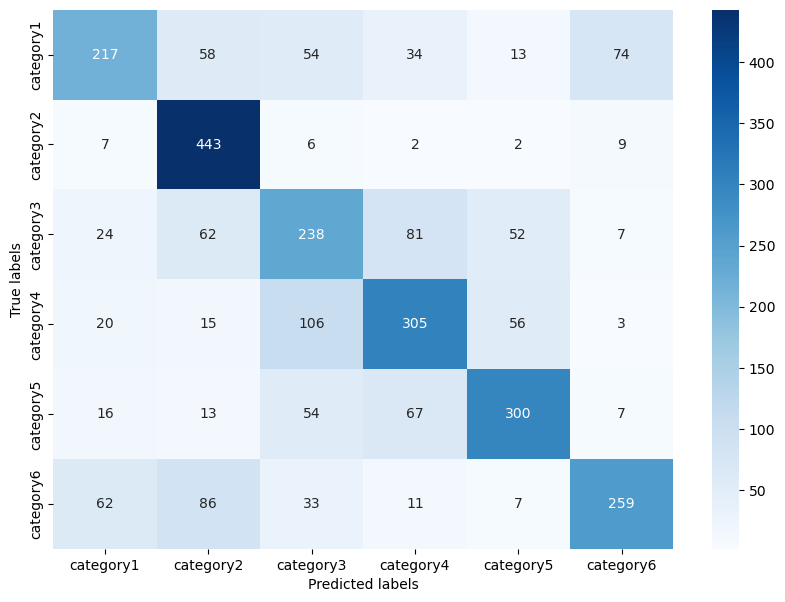

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [54]:
## Box Plot Analysis

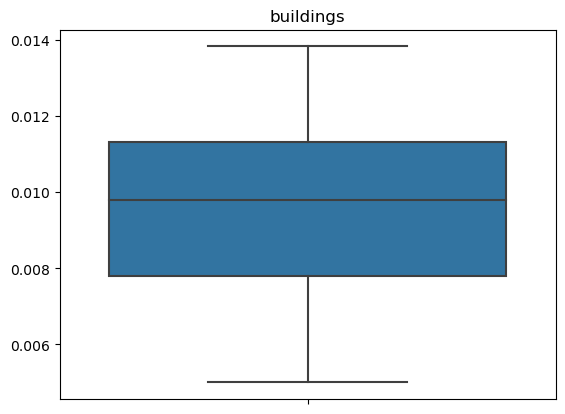

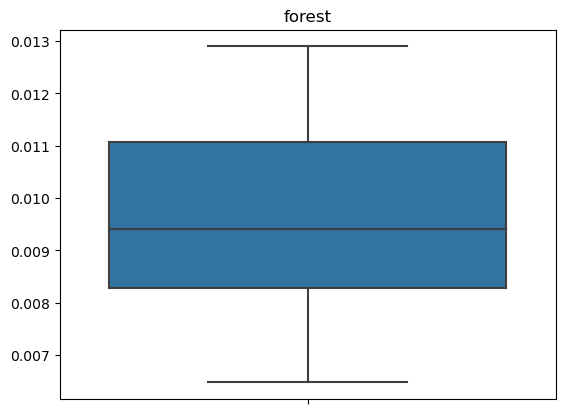

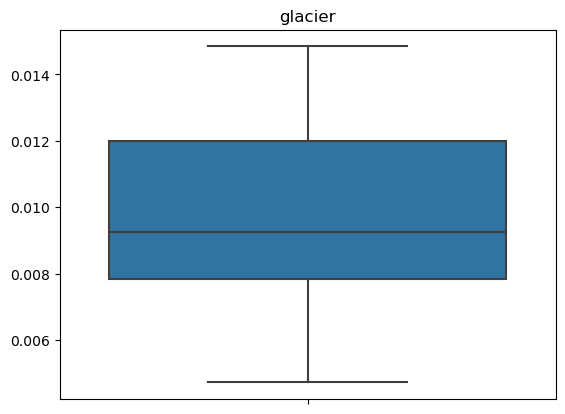

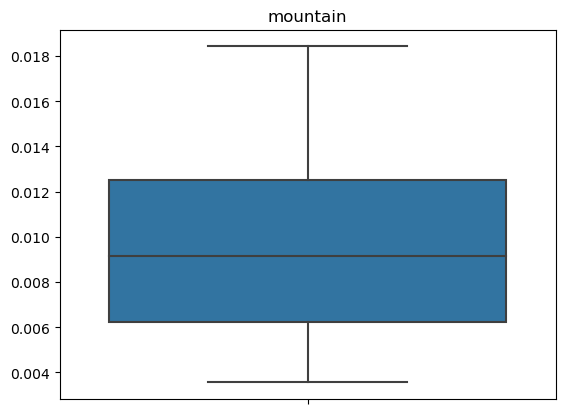

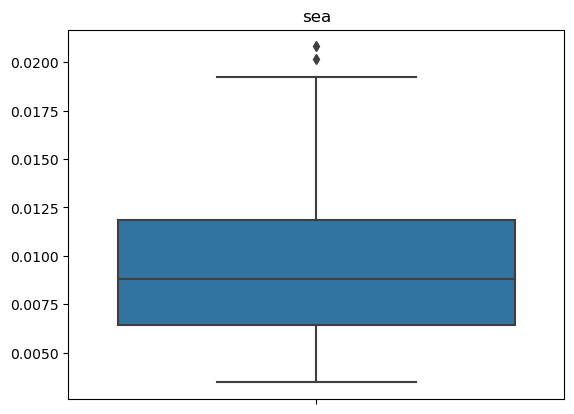

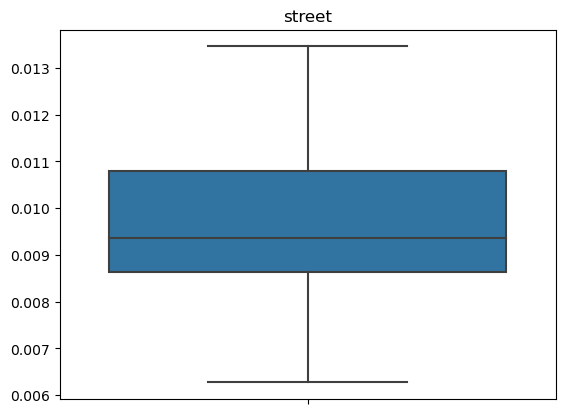

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean of features for each category
means = {category: np.mean(features, axis=0) for category, features in all_features.items()}
# Display them using boxplots
for category, feature in means.items():
    sns.boxplot(y=feature)
    plt.title(category)
    plt.show()


In [53]:
##Heatmap Analysis

Category: category1, Shape: (1, 104)
Category: category2, Shape: (1, 104)
Category: category3, Shape: (1, 104)
Category: category4, Shape: (1, 104)
Category: category5, Shape: (1, 104)
Category: category6, Shape: (1, 104)


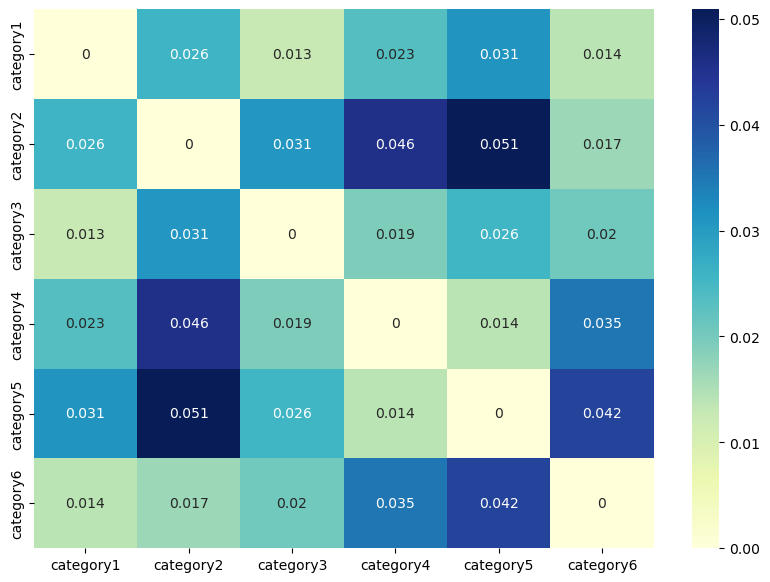

In [67]:
for category, feature in zip(categories, mean_features):
    print(f"Category: {category}, Shape: {feature.shape}")

def flatten_and_align(features):
    # Flatten each feature
    flattened = [f.flatten() for f in features]
    
    # Determine the minimum length
    min_len = min([f.size for f in flattened])
    
    # Trim each feature to the minimum length
    aligned = [f[:min_len] for f in flattened]
    
    return np.array(aligned)

aligned_mean_features = flatten_and_align(mean_features)

distances = pdist(aligned_mean_features, metric='euclidean')
distance_matrix = squareform(distances)

plt.figure(figsize=(10, 7))
sns.heatmap(distance_matrix, annot=True, xticklabels=categories, yticklabels=categories, cmap='YlGnBu')
plt.show()
